# 🏥 OPD & Doctor Performance Analytics  
## 📗 Notebook 2 — SQL Analysis & Visual Insights  

This notebook contains **8 mandatory SQL tasks** executed on the `hospital.db` database.

Each task includes:  
✔ SQL Query  
✔ Python Execution  
✔ DataFrame Output  
✔ Visualization  
✔ Business Insight Explanation  

These analytics help healthcare management understand OPD trends, doctor efficiency, revenue flow, and patient behavior.


In [2]:
# -------------------------------------------------------------
# Import Required Libraries
# -------------------------------------------------------------
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Connect to DB
conn = sqlite3.connect("hospital.db")

print("Database connected successfully!")


Database connected successfully!


In [2]:
# Check available tables
pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)


,name
0,Branch
1,Doctor
2,OPD_Visit
3,OPD_Diagnosis
4,OPD_Prescription
5,OPD_Billing


## 📊 Task 1 — Doctor-wise Monthly OPD Load  
This query calculates how many OPD visits each doctor handled every month.
- It groups visits by doctor and month
- Counts total visits handled by each doctor
- Helps identify busiest doctors and seasonal OPD patterns

This is useful for workload analysis and doctor scheduling optimization.

In [7]:
query = """
SELECT 
    v.doctor_id,
    d.doctor_name,
    d.specialization,
    strftime('%Y-%m', v.visit_datetime) AS month,
    COUNT(*) AS total_visits
FROM OPD_Visit v
JOIN Doctor d ON v.doctor_id = d.doctor_id
GROUP BY v.doctor_id, month
ORDER BY month, total_visits DESC;
"""
df1 = pd.read_sql_query(query, conn)
df1


,doctor_id,doctor_name,specialization,month,total_visits
0,11,Kritika Brar,Cardiology,2023-01,76
1,18,Anamika Kanda,General Physician,2023-01,72
2,29,Harini Choudhury,Cardiology,2023-01,72
3,34,Ekiya Suresh,ENT,2023-01,72
4,39,Siddharth Zacharia,Neurology,2023-01,69
...,...,...,...,...,...
1315,39,Siddharth Zacharia,Neurology,2025-09,45
1316,2,Liam Chaudry,General Physician,2025-09,42
1317,16,Shaurya Loke,Dermatology,2025-09,41
1318,4,Tejas Kaul,Cardiology,2025-09,39


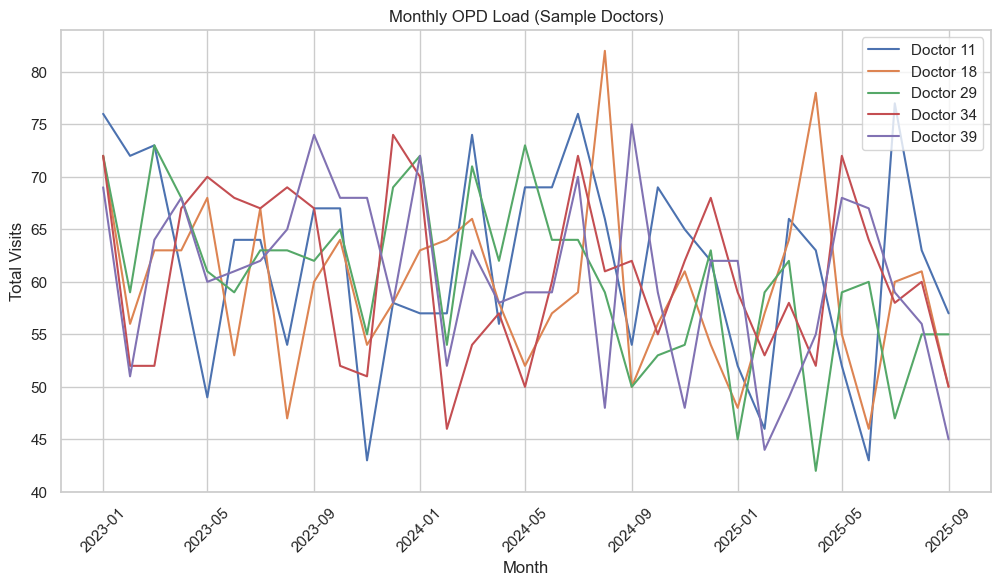

In [25]:
df_plot = df1.copy()

df_plot['month'] = pd.to_datetime(df_plot['month'])

plt.figure(figsize=(12,6))

for doc in df_plot['doctor_id'].unique()[:5]:   # first 5 doctors
    temp = df_plot[df_plot['doctor_id'] == doc]
    plt.plot(temp['month'], temp['total_visits'], label=f"Doctor {doc}")

plt.title("Monthly OPD Load (Sample Doctors)")
plt.xlabel("Month")
plt.ylabel("Total Visits")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


### Insight  
This shows which months have the highest patient load.  
Useful for:  
- Staffing decisions  
- Predicting peak OPD seasons  
- Resource planning  


## Task 1.1: Top 5 busiest doctors per month


In [26]:
import pandas as pd
import sqlite3

# Connect to SQLite DB
conn = sqlite3.connect("hospital.db")

# SQL Query: Top 5 busiest doctors per month
query_task1 = """
WITH monthly_load AS (
    SELECT 
        v.doctor_id,
        d.doctor_name,
        d.specialization,
        strftime('%Y-%m', v.visit_datetime) AS month,
        COUNT(*) AS total_visits
    FROM OPD_Visit v
    JOIN Doctor d ON v.doctor_id = d.doctor_id
    GROUP BY v.doctor_id, month
),

ranked AS (
    SELECT *,
        ROW_NUMBER() OVER (
            PARTITION BY month 
            ORDER BY total_visits DESC
        ) AS rank
    FROM monthly_load
)

SELECT *
FROM ranked
WHERE rank <= 5
ORDER BY month, rank;
"""

df_task1 = pd.read_sql_query(query_task1, conn)
df_task1.head(15)


,doctor_id,doctor_name,specialization,month,total_visits,rank
0,11,Kritika Brar,Cardiology,2023-01,76,1
1,18,Anamika Kanda,General Physician,2023-01,72,2
2,29,Harini Choudhury,Cardiology,2023-01,72,3
3,34,Ekiya Suresh,ENT,2023-01,72,4
4,39,Siddharth Zacharia,Neurology,2023-01,69,5
5,35,Janani Mohanty,Orthopedics,2023-02,78,1
6,11,Kritika Brar,Cardiology,2023-02,72,2
7,15,Janya Gaba,ENT,2023-02,70,3
8,10,Caleb Sharaf,General Physician,2023-02,68,4
9,25,Gavin Batta,ENT,2023-02,66,5


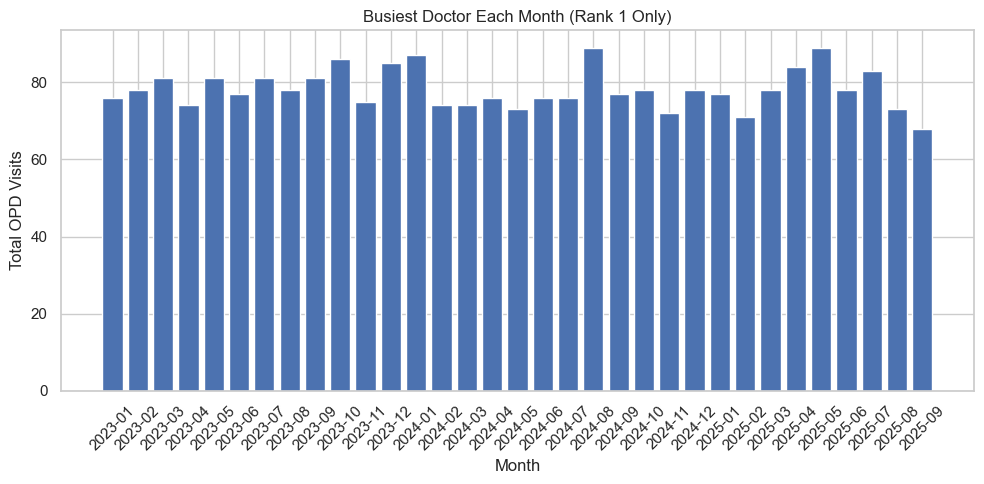

In [28]:
import matplotlib.pyplot as plt

# Filter only rank 1 (busiest doctor per month)
top1 = df_task1[df_task1["rank"] == 1]

plt.figure(figsize=(10, 5))
plt.bar(top1["month"], top1["total_visits"])
plt.xlabel("Month")
plt.ylabel("Total OPD Visits")
plt.title("Busiest Doctor Each Month (Rank 1 Only)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Task 2 — New vs Follow-up Patient Ratio (Per Branch, Per Month)

Shows the proportion of new vs returning patients.
A high follow-up ratio indicates good doctor-patient continuity.
A high new-patient ratio indicates branch growth or marketing effectiveness.



In [9]:
query = """
SELECT 
    branch_id,
    strftime('%Y-%m', visit_datetime) AS month,
    SUM(CASE WHEN consultation_type='New' THEN 1 ELSE 0 END) AS new_visits,
    SUM(CASE WHEN consultation_type='Follow-up' THEN 1 ELSE 0 END) AS followup_visits
FROM OPD_Visit
GROUP BY branch_id, month
ORDER BY month, branch_id;
"""
df2 = pd.read_sql_query(query, conn)
df2


,branch_id,month,new_visits,followup_visits
0,1,2023-01,184,423
1,2,2023-01,178,444
2,3,2023-01,168,447
3,4,2023-01,185,437
4,1,2023-02,149,416
...,...,...,...,...
127,4,2025-08,183,439
128,1,2025-09,142,390
129,2,2025-09,158,376
130,3,2025-09,163,404


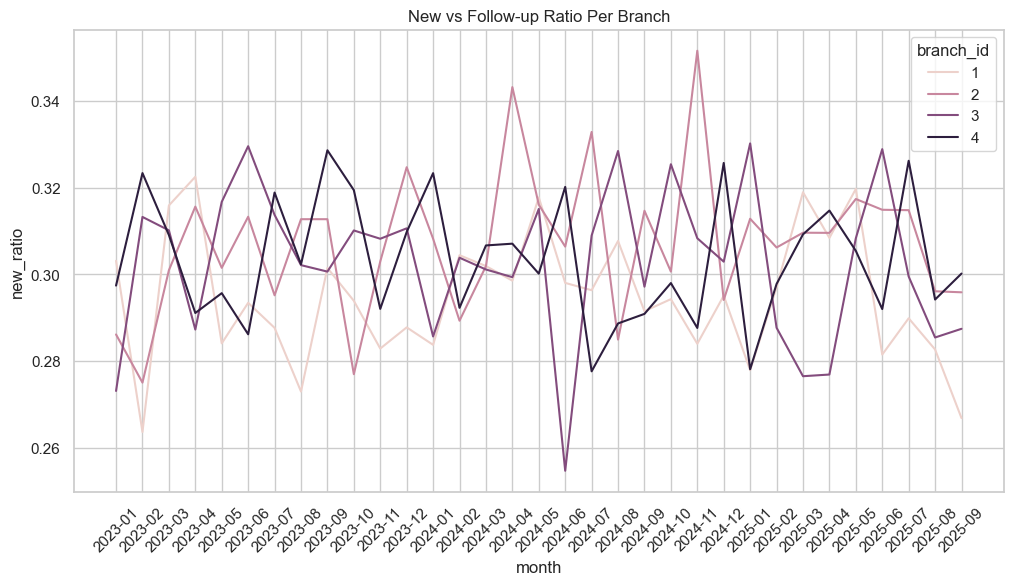

In [32]:
df2["new_ratio"] = df2["new_visits"] / (df2["new_visits"] + df2["followup_visits"])

sns.lineplot(data=df2, x="month", y="new_ratio", hue="branch_id")
plt.xticks(rotation=45)
plt.title("New vs Follow-up Ratio Per Branch")
plt.show()


### Task 3 — Top 3 Diagnoses per Specialization

Shows the most common diseases handled by each specialty.
This helps in:
- Medicine procurement
- Doctor staffing decisions
- Predicting seasonal disease trends


In [11]:
query = """
SELECT 
    d.specialization,
    diag.diagnosis_name,
    COUNT(*) AS total_cases
FROM OPD_Diagnosis diag
JOIN OPD_Visit v ON diag.visit_id = v.visit_id
JOIN Doctor d ON v.doctor_id = d.doctor_id
GROUP BY d.specialization, diag.diagnosis_name
ORDER BY d.specialization, total_cases DESC;
"""
df3 = pd.read_sql_query(query, conn)

# Take top 3 per specialization
top3 = df3.groupby("specialization").head(3)
top3


,specialization,diagnosis_name,total_cases
0,Cardiology,Migraine,3146
1,Cardiology,Hypertension,3130
2,Cardiology,Common Cold,3110
7,Dermatology,Common Cold,1179
8,Dermatology,Diabetes,1177
9,Dermatology,Bronchitis,1140
14,ENT,Hypertension,2706
15,ENT,Common Cold,2701
16,ENT,Bronchitis,2688
21,General Physician,Hypertension,3429


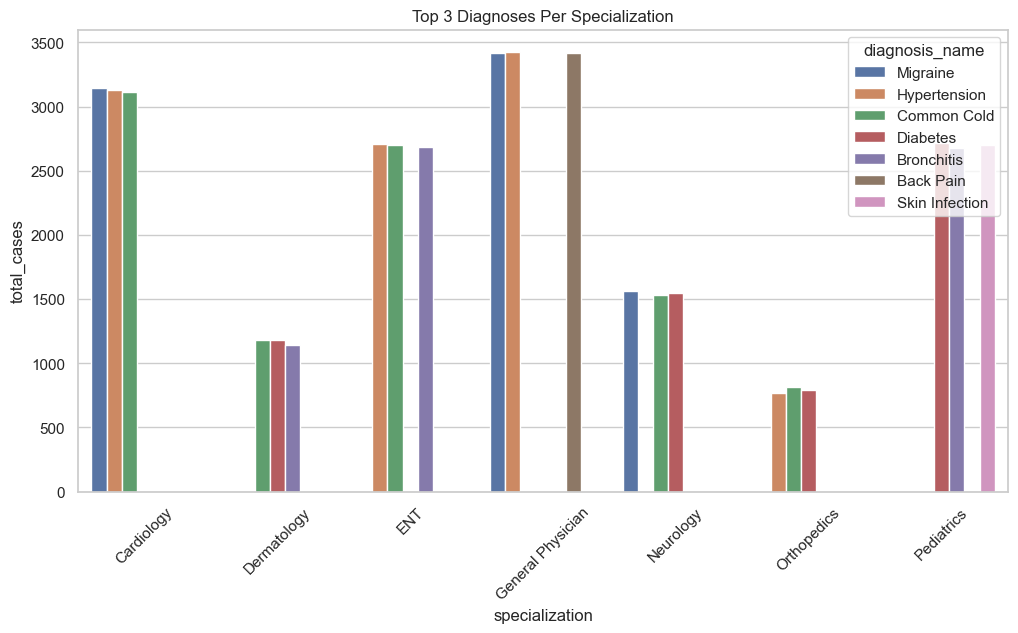

In [30]:
sns.barplot(data=top3, x="specialization", y="total_cases", hue="diagnosis_name")
plt.xticks(rotation=45)
plt.title("Top 3 Diagnoses Per Specialization")
plt.show()


### Task 4 — Most Prescribed Medicines (Unique Patient Count)

This analysis identifies which medicines are prescribed to the highest number of unique patients.
It highlights:
- The most frequently required medications
- Patient demand trends for specific drugs
- Useful insights for pharmacy inventory planning
- Understanding disease treatment patterns across branches


In [13]:
query = """
SELECT 
    p.medicine_name,
    COUNT(*) AS total_prescriptions,
    COUNT(DISTINCT v.patient_id) AS unique_patients
FROM OPD_Prescription p
JOIN OPD_Visit v ON p.visit_id = v.visit_id
GROUP BY p.medicine_name
ORDER BY unique_patients DESC;
"""
df4 = pd.read_sql_query(query, conn)
df4


,medicine_name,total_prescriptions,unique_patients
0,Amoxicillin,11447,8298
1,Atorvastatin,11545,8283
2,Metformin,11416,8273
3,Paracetamol,11471,8244
4,Azithromycin,11371,8214
5,Cetirizine,11292,8134
6,Pantoprazole,11285,8123


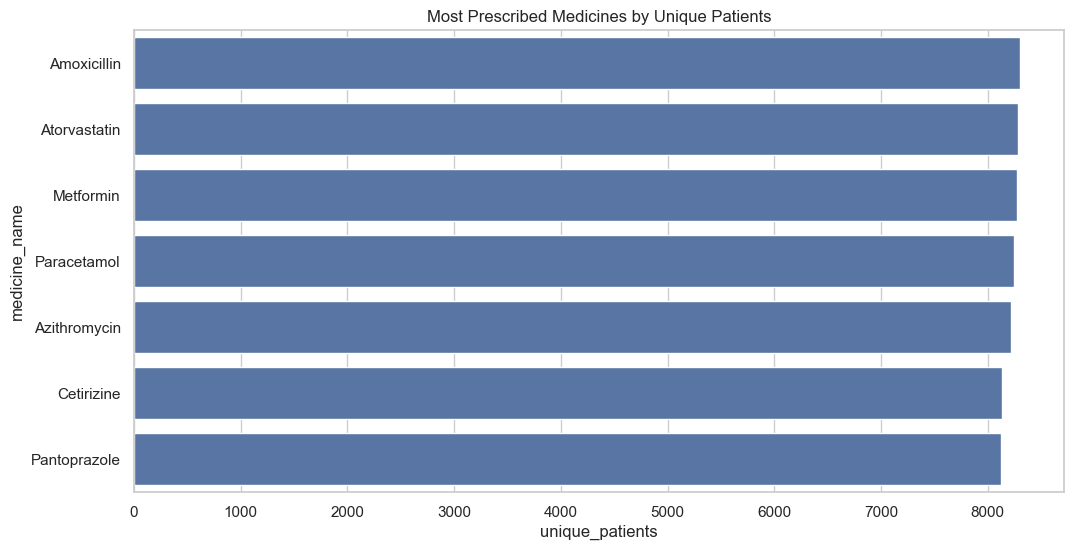

In [14]:
sns.barplot(data=df4, x="unique_patients", y="medicine_name")
plt.title("Most Prescribed Medicines by Unique Patients")
plt.show()


### Task 5 — Monthly Revenue per Branch (Gross & Net)

This query calculates both gross and net revenue generated per branch each month.
It helps understand:
- Revenue performance trends across different branches
- Seasonal increases or drops in patient spending
- Financial insights for managerial decision-making
- Which branch contributes the most to overall earnings


In [15]:
query = """
SELECT 
    v.branch_id,
    strftime('%Y-%m', v.visit_datetime) AS month,
    SUM(b.consultation_fee + b.additional_charges) AS gross_revenue,
    SUM(b.consultation_fee + b.additional_charges - b.discount_amount) AS net_revenue
FROM OPD_Billing b
JOIN OPD_Visit v ON b.visit_id = v.visit_id
GROUP BY v.branch_id, month
ORDER BY v.branch_id, month;
"""
df5 = pd.read_sql_query(query, conn)
df5


,branch_id,month,gross_revenue,net_revenue
0,1,2023-01,656585.99,637785.99
1,1,2023-02,633083.91,616383.91
2,1,2023-03,679542.30,660542.30
3,1,2023-04,657099.62,640399.62
4,1,2023-05,710453.13,692803.13
...,...,...,...,...
127,4,2025-05,718382.59,698782.59
128,4,2025-06,642057.97,622557.97
129,4,2025-07,656645.57,639595.57
130,4,2025-08,661140.87,642940.87


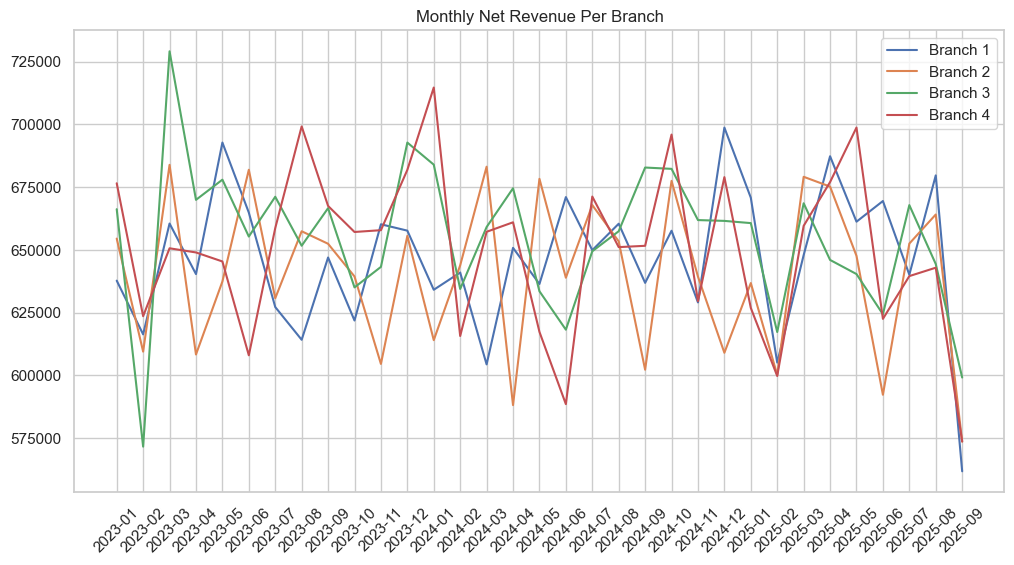

In [16]:
for branch in df5["branch_id"].unique():
    temp = df5[df5["branch_id"] == branch]
    plt.plot(temp["month"], temp["net_revenue"], label=f"Branch {branch}")

plt.xticks(rotation=45)
plt.legend()
plt.title("Monthly Net Revenue Per Branch")
plt.show()


### Task 6 — Average Ticket Size by Payment Mode

This analysis compares how much patients typically pay based on their payment method.
It helps in:
- Understanding patient payment behavior (Cash, Card, UPI, Insurance)
- Identifying high-value payment modes
- Improving billing workflows and digital payment strategies
- Optimizing financial operations based on patient preferences


In [48]:
query = """
SELECT 
    payment_mode,
    COUNT(*) AS total_bills,
    ROUND(AVG(consultation_fee + additional_charges - discount_amount), 2) AS avg_ticket_size
FROM OPD_Billing
GROUP BY payment_mode
ORDER BY avg_ticket_size DESC;
"""
df6 = pd.read_sql_query(query, conn)
df6


,payment_mode,total_bills,avg_ticket_size
0,UPI,20034,1072.65
1,Cash,19962,1069.34
2,Insurance,20025,1067.92
3,Card,19979,1066.07


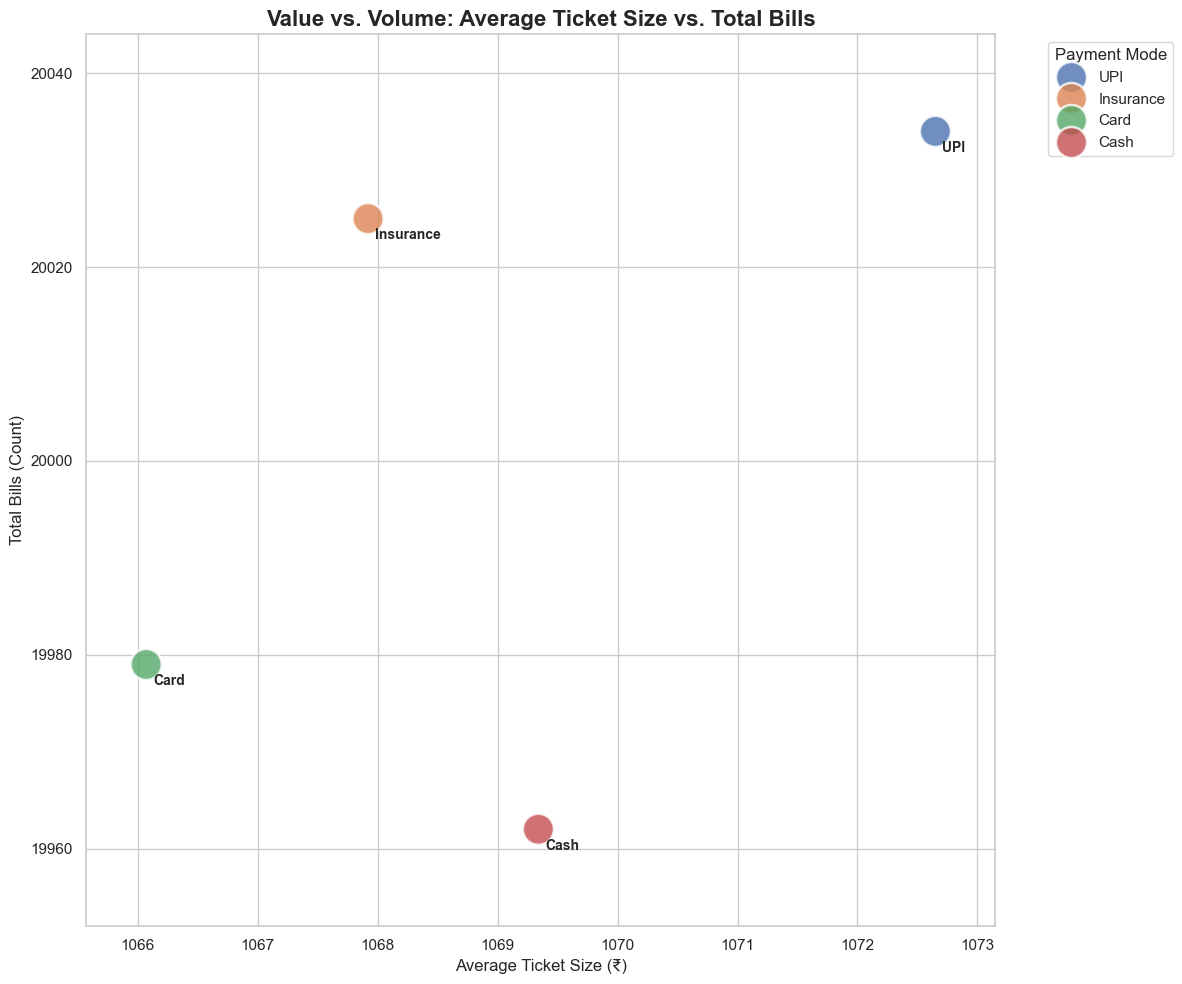

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure for a single Bubble Chart
plt.figure(figsize=(12, 10))
sns.set_style("whitegrid")

# Create the scatter plot
sns.scatterplot(
    data=df6,
    x='avg_ticket_size', # X-axis: Value
    y='total_bills',     # Y-axis: Volume
    hue='payment_mode',  # Color-code by payment mode
    s=500,               # Set point size
    alpha=0.8,
    palette='deep'
)

# --- Add Annotations and Set Zoomed Axes ---

# Calculate and set tight axis limits to zoom in on the data cluster
x_min = df6['avg_ticket_size'].min() - 0.5
x_max = df6['avg_ticket_size'].max() + 0.5
y_min = df6['total_bills'].min() - 10
y_max = df6['total_bills'].max() + 10

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

# Annotate each point with its payment mode
for i, row in df6.iterrows():
    plt.annotate(
        row['payment_mode'],
        (row['avg_ticket_size'], row['total_bills']),
        textcoords="offset points",
        xytext=(5, -15),
        ha='left',
        fontsize=10,
        fontweight='bold'
    )

# Set final titles and legend
plt.title('Value vs. Volume: Average Ticket Size vs. Total Bills', fontsize=16, fontweight='bold')
plt.xlabel('Average Ticket Size (₹)', fontsize=12)
plt.ylabel('Total Bills (Count)', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Payment Mode')

plt.tight_layout()
plt.show()

### Task 7 — Doctor Performance Analysis

Evaluates each doctor’s contribution based on patient visits, total revenue generated, and average consultation fee.
This helps in:
- Identifying high-performing doctors
- Planning bonuses, incentives, and scheduling
- Understanding specialization-wise revenue contribution
- Workforce planning and resource optimization


In [36]:
#in this Perfomance of doctor is calculated by their total revenue

query = """
SELECT 
    d.doctor_id,
    d.doctor_name,
    d.specialization,
    COUNT(v.visit_id) AS total_visits,
    SUM(b.consultation_fee + b.additional_charges - b.discount_amount) AS total_revenue,
    ROUND(AVG(b.consultation_fee + b.additional_charges - b.discount_amount), 2) AS avg_fee
FROM Doctor d
LEFT JOIN OPD_Visit v ON d.doctor_id = v.doctor_id
LEFT JOIN OPD_Billing b ON v.visit_id = b.visit_id
GROUP BY d.doctor_id
ORDER BY total_revenue DESC;
"""
df7 = pd.read_sql_query(query, conn)
df7
df7.head(10)



,doctor_id,doctor_name,specialization,total_visits,total_revenue,avg_fee
0,30,Nakul Setty,ENT,2093,2254697.22,1077.26
1,33,Kashvi Edwin,Dermatology,2033,2225397.64,1094.64
2,12,Janaki Handa,Cardiology,2077,2193402.47,1056.04
3,25,Gavin Batta,ENT,2040,2189361.34,1073.22
4,37,Ekapad Walia,Neurology,2053,2187345.08,1065.44
5,36,Wridesh Brar,Neurology,2060,2180696.09,1058.59
6,28,Advay Contractor,Cardiology,2036,2180094.30,1070.77
7,9,Gunbir Parmer,Cardiology,2023,2177054.79,1076.15
8,24,Janaki Kanda,General Physician,2036,2176496.78,1069.01
9,21,Simon Tata,Pediatrics,2055,2173580.91,1057.70


In [37]:
#by Using this we can find the top 3 doctor performace based on specialization


query_top3 = """
WITH doctor_stats AS (
    SELECT 
        d.doctor_id,
        d.doctor_name,
        d.specialization,
        COUNT(v.visit_id) AS total_visits
    FROM Doctor d
    LEFT JOIN OPD_Visit v ON d.doctor_id = v.doctor_id
    GROUP BY d.doctor_id
),
ranked AS (
    SELECT
        doctor_id,
        doctor_name,
        specialization,
        total_visits,
        ROW_NUMBER() OVER (PARTITION BY specialization ORDER BY total_visits DESC) AS rn
    FROM doctor_stats
)
SELECT 
    specialization,
    doctor_id,
    doctor_name,
    total_visits
FROM ranked
WHERE rn <= 3
ORDER BY specialization, total_visits DESC;
"""

df_top3 = pd.read_sql_query(query_top3, conn)
df_top3
df_top3.head(10)

,specialization,doctor_id,doctor_name,total_visits
0,Cardiology,12,Janaki Handa,2077
1,Cardiology,11,Kritika Brar,2041
2,Cardiology,28,Advay Contractor,2036
3,Dermatology,33,Kashvi Edwin,2033
4,Dermatology,31,Xiti Gokhale,1981
5,Dermatology,16,Shaurya Loke,1972
6,ENT,30,Nakul Setty,2093
7,ENT,25,Gavin Batta,2040
8,ENT,23,Adya Sangha,2014
9,General Physician,24,Janaki Kanda,2036


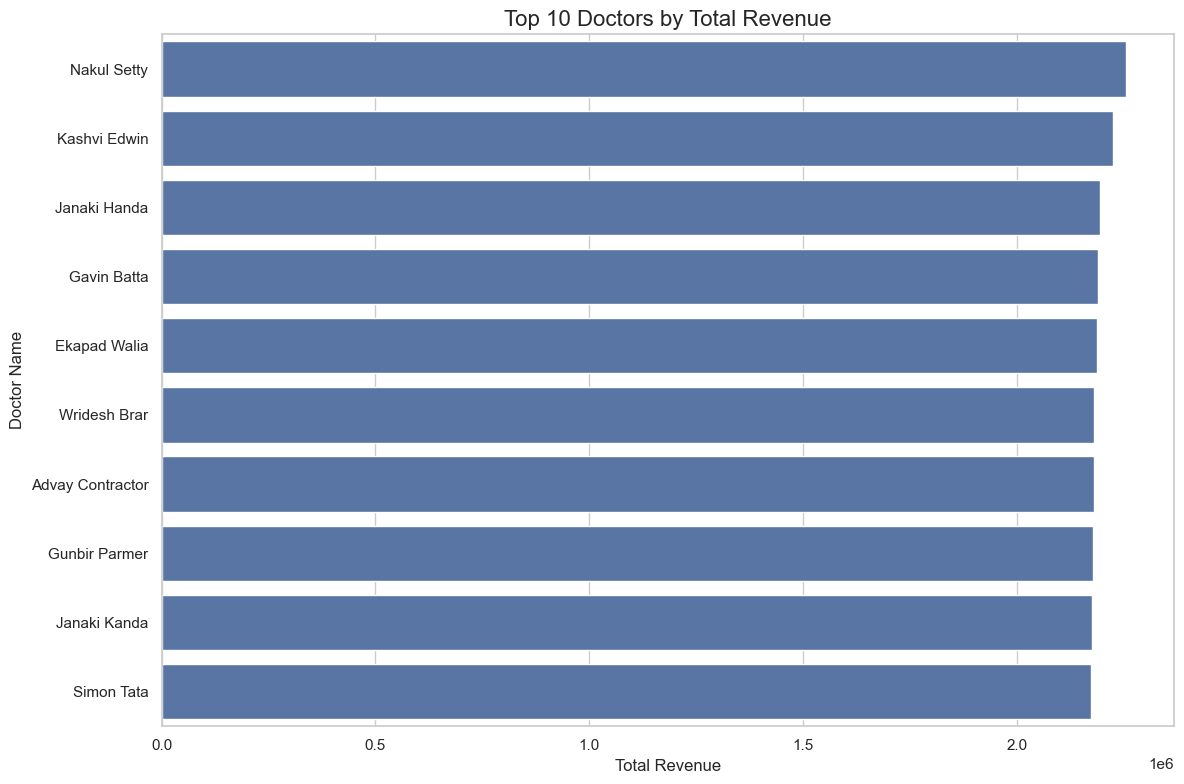

In [46]:
plt.figure(figsize=(12, 8))

sns.barplot(
    data=df7.sort_values("total_revenue", ascending=False).head(10),
    x="total_revenue",
    y="doctor_name"
)

plt.title("Top 10 Doctors by Total Revenue", fontsize=16)
plt.xlabel("Total Revenue")
plt.ylabel("Doctor Name")

plt.tight_layout()
plt.show()


### Task 8 — Peak Hour Analysis per Branch

Identifies the hour of the day when each branch experiences the highest OPD load.
This insight helps in:
- Optimal staffing during busy hours
- Managing patient flow more efficiently
- Planning appointment slots and reducing waiting time
- Improving operational efficiency during peak hours


In [12]:
query = """
WITH hourly_visits AS (
    SELECT 
        branch_id,
        strftime('%H', visit_datetime) AS hour,
        COUNT(*) AS visits
    FROM OPD_Visit
    GROUP BY branch_id, hour
)
SELECT branch_id, hour, visits
FROM (
    SELECT 
        branch_id,
        hour,
        visits,
        ROW_NUMBER() OVER (PARTITION BY branch_id ORDER BY visits DESC) AS rn
    FROM hourly_visits
)
WHERE rn = 1;
"""
df8 = pd.read_sql_query(query, conn)
df8


,branch_id,hour,visits
0,1,08,2059
1,2,17,2061
2,3,16,2096
3,4,12,2101


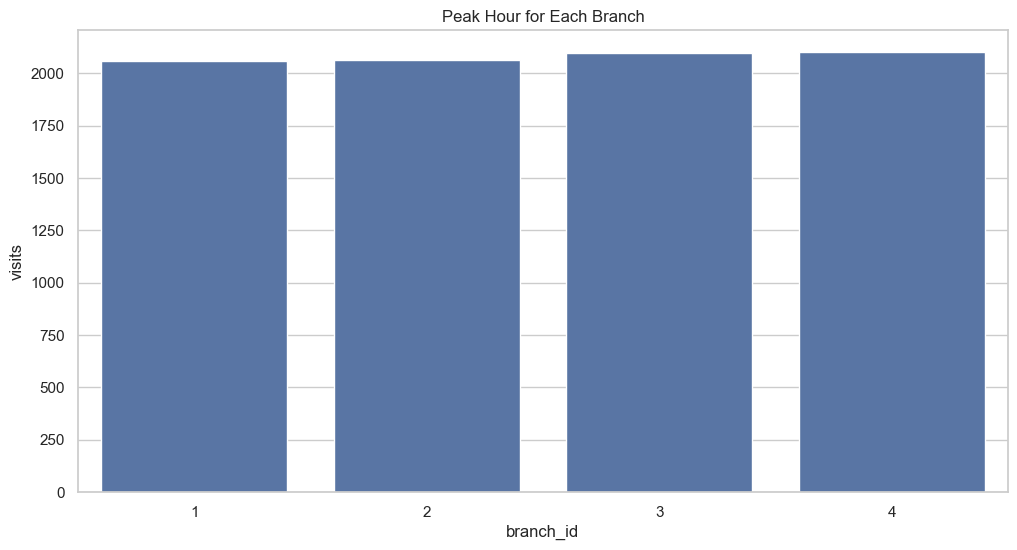

In [14]:
sns.barplot(data=df8, x="branch_id", y="visits")
plt.title("Peak Hour for Each Branch")
plt.show()


In [33]:
full_visits = pd.read_sql_query("SELECT * FROM OPD_Visit", conn)
full_visits.to_csv("dataset_csv/full_visits.csv", index=False)


In [34]:
for table in ["Branch", "Doctor", "OPD_Visit", "OPD_Diagnosis", "OPD_Prescription", "OPD_Billing"]:
    df = pd.read_sql_query(f"SELECT * FROM {table}", conn)
    df.to_csv(f"dataset_csv/{table}.csv", index=False)

print("All full table CSVs exported!")


All full table CSVs exported!


In [23]:
import os

os.makedirs("dataset_csv", exist_ok=True)

df4.to_csv("dataset_csv/medicine_popularity.csv", index=False)
df5.to_csv("dataset_csv/monthly_revenue.csv", index=False)
df7.to_csv("dataset_csv/doctor_performance.csv", index=False)
df8.to_csv("dataset_csv/peak_hours.csv", index=False)

print("All CSV files exported successfully!")


All CSV files exported successfully!
